# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# sklearn (baseline + pipeline)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

import scipy.stats as st  # for QQ plot

np.random.seed(7)
pd.set_option("display.max_columns", 100)


## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [2]:
DATA_IN = Path("../data/processed/ko_cleaned.parquet")
df = pd.read_parquet(DATA_IN).copy()

# Ensure Date is datetime and sorted
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

df.head()


,Date,close,daily_ret,log_ret
0,2000-01-03,13.815726,NaN,NaN
1,2000-01-04,13.831048,0.001109,0.001108
2,2000-01-05,13.953581,0.008859,0.008820
3,2000-01-06,13.968897,0.001098,0.001097
4,2000-01-07,14.887897,0.065789,0.063715


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [13]:
df["volatility_21d"] = df["daily_ret"].rolling(21, min_periods=21).std()

df["cum_return"] = (1 + df["daily_ret"].fillna(0)).cumprod() - 1

df[["Date","daily_ret","volatility_21d","cum_return"]].tail()


,Date,daily_ret,volatility_21d,cum_return
6443,2025-08-15,0.005320,0.009264,4.060899
6444,2025-08-18,-0.011299,0.009310,4.003718
6445,2025-08-19,0.014466,0.009841,4.076099
6446,2025-08-20,0.008128,0.009892,4.117357
6447,2025-08-21,-0.000566,0.009731,4.114462


In [14]:
# Target: next-day return
df["y_next"] = df["daily_ret"].shift(-1)

# Basic feature set (you can add more later)
feature_cols = ["volatility_21d", "cum_return"]

X = df[feature_cols].copy()
y = df["y_next"].copy()

# Drop rows with NA in X or y (from rolling/shift)
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask]
dates = df.loc[mask, "Date"]  

X.head(), y.head()


(    volatility_21d    cum_return
 21        0.032116  2.220446e-16
 22        0.032423 -1.995528e-02
 23        0.032619 -2.217392e-03
 24        0.032710  8.869223e-03
 25        0.029134  1.441315e-02,
 21   -0.019955
 22    0.018099
 23    0.011111
 24    0.005495
 25   -0.003279
 Name: y_next, dtype: float64)

In [ ]:
split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]  

len(X_train), len(X_test)


(5140, 1286)

In [16]:
y_pred = pipe.predict(X_test)
r2   = r2_score(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)  
rmse = np.sqrt(mse)

print(f"Baseline Linear Regression\nR² = {r2:.4f}   RMSE = {rmse:.6f}")


Baseline Linear Regression
R² = -0.0054   RMSE = 0.010483


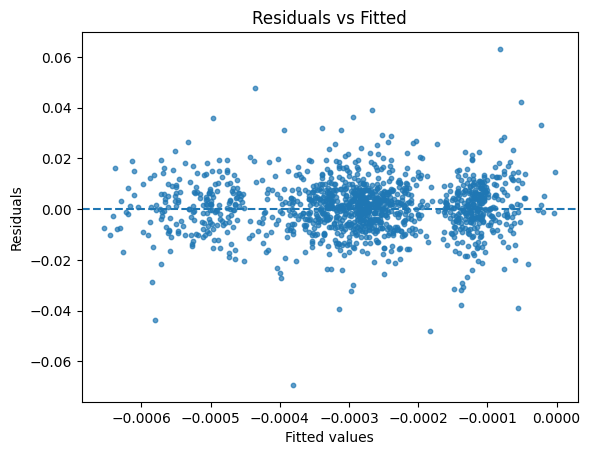

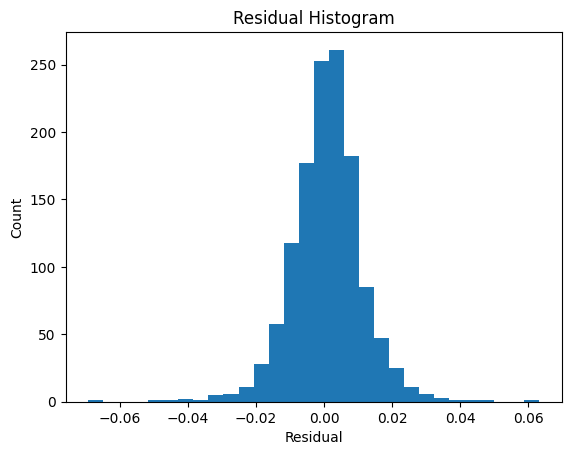

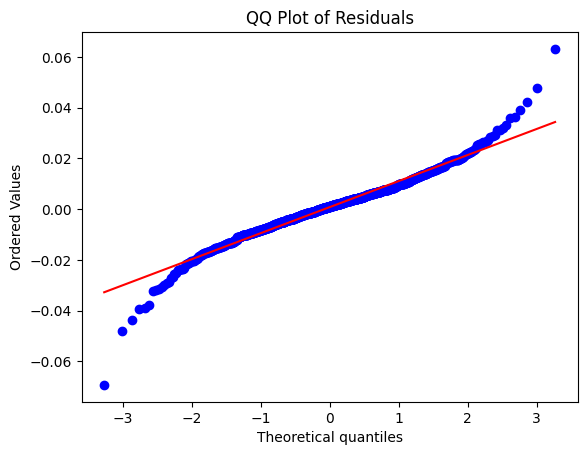

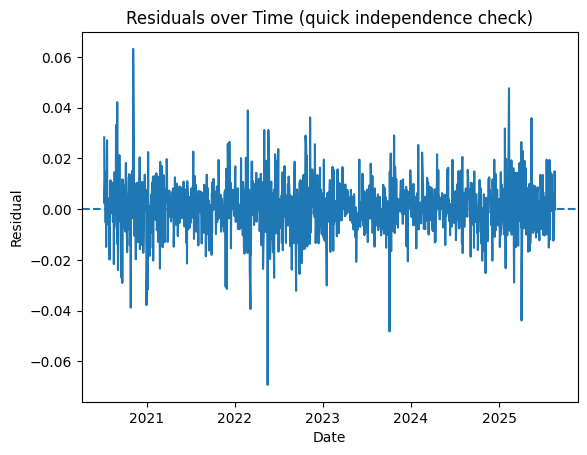

In [11]:
resid = y_test - y_pred
fitted = y_pred

# Residuals vs Fitted
plt.figure()
plt.scatter(fitted, resid, s=10, alpha=0.7)
plt.axhline(0, ls="--")
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# Residual histogram
plt.figure()
plt.hist(resid, bins=30)
plt.title("Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# QQ plot (normality)
plt.figure()
st.probplot(resid, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

# (Optional) Residuals over time
plt.figure()
plt.plot(dates_test.values, resid.values)
plt.axhline(0, ls="--")
plt.title("Residuals over Time (quick independence check)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()

## 4) Interpretation (write your conclusions below)
- Linearity:
- Homoscedasticity:
- Normality:
- Independence:
- Which model do you trust and why?:
- Next step you’d try:

The residuals vs. fitted plot shows no clear linear trend, but the points are very tightly clustered near zero. This suggests the model is not capturing meaningful linear structure — essentially, daily returns are close to noise.

The spread of residuals looks roughly constant across fitted values, which satisfies homoscedasticity.
However, clustering around different fitted levels suggests the model is not adding much explanatory power.

The histogram of residuals looks bell-shaped, centered at zero.
The QQ-plot shows deviations in the tails (fat tails), which is expected for financial returns.
This means extreme events (outliers, volatility shocks) are more common than a normal distribution assumes.

The residuals-over-time plot shows no obvious autocorrelation pattern, though some volatility clustering is visible (bursts of higher variance).
This reflects financial time series reality: returns are close to independent, but volatility is not.

The model does not provide useful predictive power; residuals are mostly noise, and financial returns are close to unpredictable at the daily scale